# Sentiment Analysis
This Python notebook is adapted from the supplementary materials for the following forthcoming book chapter:

Curini, L., Fahey, RA., "Chapter 31: Sentiment Analysis and Social Media", in _The SAGE Handbook of Research Methods in Political Science and International Relations_, Curini, L., Franzese, R. (eds.), London: Sage 2019

### Download and unpack the data for the Natural Language ToolKit (NLTK)

In [1]:
import nltk

nltk.download('opinion_lexicon')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\opinion_lexicon.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Data Import

First we need to load in the files from the Large Movie Review Dataset. Normally, the dataset is distributed in the form of two directories - which the dataset refers to as "training" and "test" sets - each containing subdirectories of positive and negative reviews, 12500 in each subdirectory. For the purposes of this workshop, we'll be using a version of the dataset I created that comes in a single file (this will save a lot of time importing the data), but you can find the ordinary version here: [Stanford Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

For this demonstration, we'll treat the full data set (50,000 reviews) as our overall _corpus_. In a later step we'll divide this into "labelled" and "unlabelled" data, emulating the normal procedure for research projects using this techniques (although in this case it's an artifical division, as in reality the entire dataset is labelled).

In [2]:
import pickle
import numpy as np

# Set the seed value for random numbers, so we all get the same results.
np.random.seed(1)      
 
with open('categories.pkl', 'rb') as inputfile:
    y = pickle.load(inputfile)
    
with open('reviews.pkl', 'rb') as inputfile:
    X = pickle.load(inputfile)

# now X is a list of all the reviews, and y is a list of all their categories

OK, let's take a look at our data! Use the box below to try out some commands to explore the lists of data contained in *X* (reviews) and *y* (positive/negative).

For example, use `len(X)` to find out how many entries are in list *X*; or to see an individual review, try `X[10]` or `X[12700]`. If you reference the element in list *y* with the same number (e.g. `y[10]` or `y[12700]`) you can see whether this review is positive (1) or negative (0).

In [3]:
# Try some commands here!
X[12700]

'Wow, I forgot how great this movie was until I stumbled upon it while looking through the garage. It\'s a kind of strange combination of a bio of Michael Jackson, a collection of musical vignettes, and a story about a super hero fighting to save some little kids. The vignettes are good (especially Speed Demon), but the best part of this movie is the super hero segment, in which Michael Jackson turns into a car, a robot, and finally a spaceship (and it\'s just as weird as it sounds). Joe Pesci is hilarious, and has enough cool imagery and great music to entertain throughout!<br /><br />The real gem however is the incredible "Smooth Criminal" video, which makes the movie worth owning for that part alone!'

# Data Cleaning and Pre-Processing

This dataset isn't drawn from social media so we don't have to worry about emoji or hashtags in this case. However, a quick look at the data will show that there are some problems - for example, there are HTML tags in the text in some places, and there are also a lot of punctuation or control characters present. Let's get rid of them. 

We find HTML tags using Regular Expressions - a very powerful and commonly used system for performing advanced searching and lookup within text.

While we're at it, we can convert the text to lower-case - we could do this at any stage in the process but might as well do it in pre-processing.

In [4]:
#regular expression
import re
from string import punctuation

# Remove HTML tags and convert to lowercase
remove_html = re.compile("<[^<]+?>")
X = [remove_html.sub(" ", a_review.lower()) for a_review in X]

# Remove all punctuation
remove_punctuation = str.maketrans('', '', punctuation)
X = [a_review.translate(remove_punctuation) for a_review in X]

In [7]:
X[10]

'i felt brain dead ill tell you this is the worst film i have ever bought in my ignorance i thought this was the peter jackson film of the same name the performances are so terrible they are laughable the special effects have not stood the test of time and look dire the script promotes that kind of tv movie stare into the middle distance kind of acting the cast look as if they have been taking lessons from joey tribbiani they have one look each and stick to it plus i have never been confused by a movie until i sat down to watch this the is it a dream or no plot is so terrible that frustration sets in within a few minutes avoid like a plague'

### Splitting into Labelled and Unlabelled sets

For the purposes of these demonstrations, we're going to randomly extract 5,000 reviews from the corpus to treat as _labelled_ (i.e. they have been categorised by human coders), with the remaining 45,000 being _unlabelled_. This is done using the `train_test_split` function from Python's `scikit-learn` package.

_(In reality, of course, we know the labels of these 45,000 reviews, and later we'll use them to measure the accuracy of the algorithms trained using the labelled set; in an actual research project, however, this data would be entirely unlabelled, so the robustness of the algorithm's predictions would have to be measured entirely using the labelled set.)_

In [8]:
from sklearn.model_selection import train_test_split

X_labelled, X_unlabelled, y_labelled, y_unlabelled = train_test_split(X, y, 
                                                                      test_size=0.9)
# This will give us 5,000 'labelled' reviews, and 45,000 'unlabelled'

len(X_labelled)

5000

***
# Dictionary / Lexicon Sentiment Analysis

We'll first test some dictionary or lexicon based sentiment analysis approaches on the data. Since these approaches don't have a training step, we'll just see how they perform on the training data itself.

For this stage, we're using the *NTLK* package for Python, which includes both the Liu & Hu Sentiment Lexicon and the VADER Sentiment Scoring lexicon and algorithm. This will allow us to see the difference between using the "naïve" Liu & Hu approach, and the more complex VADER approach.

(If you didn't install the lexicon files at the start of this Notebook, you may get an error telling you to do so now. You won't have to do this again for subsequent projects.)

"i chose to see this movie because it got a good score here on imdb but a lot of people either have really poor taste or someones been fixing the score  either way it was a real disappointment the movie is exactly as stupid and far fetched as the title would suggest there really is no reason to give a summary of the plot  but here goes it felt like someone had been thinking wouldnt it be cool to make a movie where there were snakes on a plane and then the snakes for some reason would go crazy and start biting and stuff and thats about it the plot is thin and unoriginal the snakes are bad cgi but it makes sense to cut corners on a movie that no one in their right mind will recommend to anyone the acting is poor and all people are unbelievable stereo types  to sum it up its one of the worst movies ive ever seen  stay away"

Negative


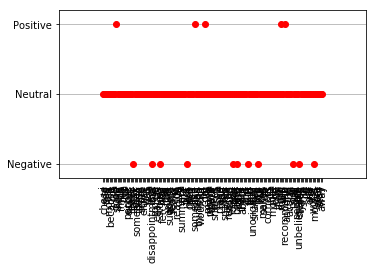

In [10]:
# Sample of Liu & Hu Lexicon output

from nltk.sentiment.util import demo_liu_hu_lexicon

print('"{}"\n'.format(X[8]))

demo_liu_hu_lexicon(X[8], plot=True)

Liu & Hu accurately classified this review - but note that it identified a number of positive words, despite the review being overwhelmingly negative. This hints at the problem Liu & Hu's lexicon has with many cases; in fact, running the algorithm over a larger data set reveals quite poor accuracy:

In [11]:
import pandas as pd
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

lexicon_positive = list(opinion_lexicon.positive())
lexicon_negative = list(opinion_lexicon.negative())

def liu_hu(a_string):
    pos_words = 0
    neg_words = 0
    for word in word_tokenize(a_string):
        if word in lexicon_positive:
            pos_words += 1
        elif word in lexicon_negative:
            neg_words += 1
    if pos_words > neg_words:
        return 'Positive'
    elif pos_words < neg_words:
        return 'Negative'
    else:
        return 'Neutral'
            
pos = [0, 0]
neu = [0, 0]
neg = [0, 0]

for a_review, actual_class in zip(X_labelled[:1000], y_labelled[:1000]):
    classification = liu_hu(a_review)
    if classification == 'Positive':
        pos[actual_class] += 1
    elif classification == 'Neutral':
        neu[actual_class] += 1
    elif classification == 'Negative':
        neg[actual_class] += 1

accuracy = ((pos[1]+neg[0])/1000)*100
print('Accuracy: {}%'.format(accuracy))
        
result_frame = pd.DataFrame(data=[neg, neu, pos], 
                            columns=['Actual-Neg', 'Actual-Pos'], 
                            index=['Predict-Neg', 'Predict-Neu', 'Predict-Pos'])

result_frame

Accuracy: 71.7%


,Actual-Neg,Actual-Pos
Predict-Neg,324,72
Predict-Neu,38,34
Predict-Pos,139,393


### Results for Liu & Hu Sentiment Lexicon

When we ran the Liu & Hu Lexicon on the full data set (which we don't have time to do in this workshop), it managed 69.6% accuracy overall - correctly scoring some 31,329 reviews, but missing the remainder. It was somewhat better at scoring positive reviews (74.3% accurate) than negative reviews (64.9%). Given how simple the Liu & Hu approach is, this is a reasonable score - but it would be questionable to draw any firm research conclusions from a classification approach with such large error margins.

Next, let's look at the more complex and context-sensitive VADER sentiment scoring system. Rather than a simple "Positive" or "Negative", this produces a probability score, with a compound score of -1 being entirely negative and +1 being entirely positive. For the purposes of this example, we'll convert that score into a Positive or Negative rating. Vader can even recognize emoji, making it suitable for social media text analysis.

In [13]:
from nltk.sentiment import vader

vader_sentiment = vader.SentimentIntensityAnalyzer()

print('"{}"'.format(X[8]))

vader_sentiment.polarity_scores(X[8])
#gives you the probability distribution of positive and negative, scale from -1(very negative) to 1(very positive)

"i chose to see this movie because it got a good score here on imdb but a lot of people either have really poor taste or someones been fixing the score  either way it was a real disappointment the movie is exactly as stupid and far fetched as the title would suggest there really is no reason to give a summary of the plot  but here goes it felt like someone had been thinking wouldnt it be cool to make a movie where there were snakes on a plane and then the snakes for some reason would go crazy and start biting and stuff and thats about it the plot is thin and unoriginal the snakes are bad cgi but it makes sense to cut corners on a movie that no one in their right mind will recommend to anyone the acting is poor and all people are unbelievable stereo types  to sum it up its one of the worst movies ive ever seen  stay away"


{'neg': 0.22, 'neu': 0.726, 'pos': 0.054, 'compound': -0.9888}

In [14]:
# Now to test a larger set using VADER:

pos = [0, 0]
neu = [0, 0]
neg = [0, 0]

for a_review, actual_class in zip(X_labelled[:1000], y_labelled[:1000]):
    classification = vader_sentiment.polarity_scores(a_review)['compound']
    if classification > 0:
        pos[actual_class] += 1
    elif classification < 0:
        neg[actual_class] += 1
    elif classification == 0:
        neu[actual_class] += 1

accuracy = ((pos[1]+neg[0])/1000)*100
print('Accuracy: {}%'.format(accuracy))

vader_result_frame = pd.DataFrame(data=[neg, neu, pos], 
                                  columns=['Actual-Neg', 'Actual-Pos'], 
                                  index=['Predict-Neg', 'Predict-Neu', 'Predict-Pos'])

vader_result_frame

Accuracy: 69.89999999999999%


,Actual-Neg,Actual-Pos
Predict-Neg,258,58
Predict-Neu,0,0
Predict-Pos,243,441


### Results for VADER Sentiment Analysis

In tests on the full data set, VADER achieved very similar results to the Liu & Hu Lexicon in this test - correctly classifying 69.6% of the reviews - but it skewed very strongly towards positive classifications. 85.2% of positive reviews were correctly classified, compared to only 54.0% of negative reviews, and there was a high probability of a negative review being misclassified as positive.

Since VADER is specifically designed to work with social media texts, it is likely that a data set drawn from Twitter or Facebook would show a more consistent performance for this algorithm.

***

# Classification Algorithms

The next set of approaches we will demonstrate are the classification algorithms. For this set of algorithms, we divide the labelled data into _training_ and _test_ sets, train a model using the `training set`, and then test its effectiveness on the `test set`. To ensure reliability, the training and test sets are divided up into multiple folds and the algorithms trained and tested repeatedly to ensure reliability - a process known as _cross-validation_. In this example, we'll also be able to check the performance of the trained algorithm on our "unlabelled" data (since in reality we do have labels for that data - we just don't show them to the algorithm during the training stage). In a real-world research project, this final check would not be possible, so the reliability of the algorithm must be determined entirely from its performance on the labelled data set. 


### Constructing a Document-Term Matrix

The first step before doing any classification is to turn our corpus of texts into word vectors, known as a Document-Term Matrix. This represents each document as a binary vector where an element is 1 if that vocabulary word is present, and 0 if it is not present.

In order to tidy up our data a little, we will apply a stemmer to the words (reducing them to a stem according to their core meaning) and also remove "stopwords" - words like "the" and "a" which appear very frequently but have little or no relevance to the sentiment of a text. We then "fit" the vectorizer to the labelled set, allowing it to learn which vocabulary words are relevant and which to exclude from its vectors.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

class StemTokenize(object):
    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)
    def __call__(self, articles):
        return [self.stemmer.stem(t) for t in word_tokenize(articles)]

dtm_vectorizer = CountVectorizer(tokenizer=StemTokenize(),
                                 stop_words = list(stopwords.words('english')),
                                 binary = True,
                                 max_df = 0.5,  #document frequency > 0.5, remove them cuz they are not useful and unique features
                                 max_features = 500) 

# 'binary' creates boolean (0 or 1) vectors, rather than term frequencies
# 'max_df' removes any word appearing in more than that proportion of documents
# 'max_features' selects the top N features by frequency

dtm_vectorizer.fit(X_labelled)

C:\Users\Anna\Anaconda2\envs\Python3.7\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=500, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<__main__.StemTokenize object at 0x000001F13A2A1898>,
        vocabulary=None)

In [16]:
#fit the train and test data to document term matrix
X_labelled_dtm = dtm_vectorizer.transform(X_labelled)
X_unlabelled_dtm = dtm_vectorizer.transform(X_unlabelled)

X_labelled_dtm

<5000x500 sparse matrix of type '<class 'numpy.int64'>'
	with 228323 stored elements in Compressed Sparse Row format>

`X_unlabelled_dtm` and `X_labelled_dtm` now hold large, sparse matrices of data - 500 vocabulary columns for each of the 45,000 unlabelled reviews and 5,000 labelled reviews in the data set. We call this kind of array "sparse" because the vast majority of entries in the matrix will be zero; this property of the data allows it to be stored in a computer's memory very efficiently, because we only need to store the locations of the cells which hold data, not of all the zero cells.

### Testing the algorithms

Let's begin testing classification algorithms with one of the most simple (but often effective) varieties, Naive Bayes. We'll try out two variations of this algorithm - Multinomial Naive Bayes, and Bernoulli Naive Bayes. The important thing to note here is that the script to train each algorithm is almost identical. This is common across classification algorithms; it's easy to train and test multiple algorithms quickly using pretty much the same lines of Python or R.

There are many classification algorithms - from simple methods likeNaive Bayes, to evaluations of regression-based approaches like Support Vector Machine, Random Forest, Neural Networks.

In order to carry out the test, we need to sub-divide our labelled data into **training** and **test** sets. The algorithm will be trained using only the training set of data; then the unseen test set will be used to measure its performance. In order to ensure that the algorithm performs consistently on this data set, we use a process called **cross validation** - whereby we divide the labelled data into multiple "folds", and train the algorithm on each fold in turn, testing it on the remainder of the data. If it performs consistently strongly across all of the folds, we can say with some confidence that it should give similarly good performance when it's used to predict the classifications of the _unlabelled_ data. This is implemented in _scikit-learn_ using the `cross_val_score` function.


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

m_mnb = MultinomialNB()
cv_mnb = cross_val_score(m_mnb, X_labelled_dtm, y_labelled, cv=3)
print('\n[Multinomial Naive Bayes]')
print("Accuracy: {:0.3f} (Std. Error: +/-{:0.03f}) - {}".format(cv_mnb.mean(),
                                                                cv_mnb.std() * 2,
                                                                cv_mnb))

m_bnb = BernoulliNB()
cv_bnb = cross_val_score(m_bnb, X_labelled_dtm, y_labelled, cv=3)
print('\n[Bernoulli Naive Bayes]')
print("Accuracy: {:0.3f} (Std. Error: +/-{:0.03f}) - {}".format(cv_bnb.mean(),
                                                                cv_bnb.std() * 2,
                                                                cv_bnb))


[Multinomial Naive Bayes]
Accuracy: 0.824 (Std. Error: +/-0.013) - [0.81883623 0.81943611 0.83253301]

[Bernoulli Naive Bayes]
Accuracy: 0.813 (Std. Error: +/-0.014) - [0.81703659 0.80383923 0.81932773]


We do cross-validation: cut your data into a few segments and cross train and test on each subsets, in order to make sure that your algorithm fits for every subset, instead of happened to perform well on one specific subset. The more variation in your data (ex. social media), you need to train more percentage of your data; while working on newspaper context, your train size could be at least as 0.1.

Already we can see that classification algorithms offer a dramatic improvement over the lexicon-based approaches we have been using so far, with both versions of Naive Bayes achieving over 80% accuracy on the test set of data.

In the following section we will test multiple other algorithms - Support Vector Classification, Stochastic Gradient Descent, Random Forest, and a Neural Network (Multi-level Perceptron). Random Forest and Neural Network models are particularly complex and may take much longer to train than the other models; in some instances this is worthwhile as the model is much more accurate, but this is not always the case.

In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

m_svc = SVC(max_iter=-1, gamma='auto')
cv_svc = cross_val_score(m_svc, X_labelled_dtm, y_labelled, cv=3)
print('\n[Support Vector Classification]')
print("Accuracy: {:0.3f} (Std. Error: +/-{:0.03f}) - {}".format(cv_svc.mean(),
                                                                cv_svc.std() * 2,
                                                                cv_svc))

m_sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3, shuffle=True)
cv_sgd = cross_val_score(m_sgd, X_labelled_dtm, y_labelled, cv=3)
print('\n[Stochastic Gradient Descent (hinge, l2)]')
print("Accuracy: {:0.3f} (Std. Error: +/-{:0.03f}) - {}".format(cv_sgd.mean(),
                                                                cv_sgd.std() * 2,
                                                                cv_sgd))

m_for10 = RandomForestClassifier(n_estimators=10)
cv_for10 = cross_val_score(m_for10, X_labelled_dtm, y_labelled, cv=3)
print('\n[Random Forest (10 trees)]')
print("Accuracy: {:0.3f} (Std. Error: +/-{:0.03f}) - {}".format(cv_for10.mean(),
                                                                cv_for10.std() * 2,
                                                                cv_for10))

m_mlp = MLPClassifier(hidden_layer_sizes=(500,250,100))
cv_mlp = cross_val_score(m_mlp, X_labelled_dtm, y_labelled, cv=3)
print('\n[Neural Network (Multi-layer Perceptron)]')
print("Accuracy: {:0.3f} (Std. Error: +/-{:0.03f}) - {}".format(cv_mlp.mean(),
                                                                cv_mlp.std() * 2,
                                                                cv_mlp))


[Support Vector Classification]
Accuracy: 0.816 (Std. Error: +/-0.009) - [0.80923815 0.81883623 0.81932773]

[Stochastic Gradient Descent (hinge, l2)]
Accuracy: 0.796 (Std. Error: +/-0.022) - [0.78104379 0.80503899 0.80312125]

[Random Forest (10 trees)]
Accuracy: 0.731 (Std. Error: +/-0.019) - [0.72525495 0.72405519 0.74489796]

[Neural Network (Multi-layer Perceptron)]
Accuracy: 0.809 (Std. Error: +/-0.014) - [0.79904019 0.81403719 0.81272509]


### Classification Algorithm Results

There are a number of important points to note in the results from the classification algorithms. Firstly, there is no one-size-fits-all classification algorithm, and more modern, complex approaches like neural networks are not necessarily going to outperform simple algorithms like Naive Bayes. The performance of the different algorithms can vary widely depending on the data being classified; the only way to determine the most appropriate algorithm for your data is to carry out this process of training and testing different types. In this particular instance, the Linear Support Vector Classifier had by far the worst performance of any model tested, but in other sentiment analysis projects it can and will be the top performer.

Additionally, many algorithms take a range of "hyper-parameters" which are used to fine-tune the model. Discovering the ideal parameters for a specific algorithm and a specific data set is also a process of trial and error - but this, too, can be automated to a large extent. The `scikit-learn` package provides a function called `GridSearchCV` which allows the automated construction and testing of an exhaustive set of combinations of parameter values.  Note that the "grid" of hyper-parameters you define (`test_parameters` in the below script) will be different for every algorithm - check the _scikit-learn_ documentation for details of the parameters for each algorithm. This function will also automatically perform cross-validation on the training process, as we did above.

The Support Vector Classifier achieved on average 81.9% accuracy in the test above - not as good as the Multinomial Naive Bayes algorithm's score, but the top-ranked among the more complex algorithms with multiple hyper-parameters. Let's now see if we can boost its score by testing different parameters using `GridSearchCV`.

In [19]:
from sklearn.model_selection import GridSearchCV

test_parameters = [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100]},
                    {'kernel': ['linear'], 
                     'C': [1, 10, 100]}]

grid_searcher = GridSearchCV(SVC(),            # Model to be tested
                             test_parameters,  # Hyper-parameters to test
                             scoring='f1',     # Performance score to use
                             cv=3,             # Folds for cross-validation
                             n_jobs=-1)        # CPU cores to use; -1 is 'all'

grid_searcher.fit(X_labelled_dtm, y_labelled)

print("Best performing hyper-parameters: {}\n".format(grid_searcher.best_params_))
print("Scores for each iteration of parameters tested:\n")
for mean, std, params in zip(grid_searcher.cv_results_['mean_test_score'], 
                             grid_searcher.cv_results_['std_test_score'], 
                             grid_searcher.cv_results_['params']):
    print("{:0.3f} (+/-{:0.03f}) for {}".format(mean, std * 2, params))

Best performing hyper-parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Scores for each iteration of parameters tested:

0.822 (+/-0.004) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.672 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.824 (+/-0.022) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.821 (+/-0.004) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.814 (+/-0.016) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.824 (+/-0.019) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.808 (+/-0.016) for {'C': 1, 'kernel': 'linear'}
0.808 (+/-0.010) for {'C': 10, 'kernel': 'linear'}
0.805 (+/-0.012) for {'C': 100, 'kernel': 'linear'}


### Results from Grid Search and Cross Validation

We can see here that - with a single exception - all of the Support Vector Classifiers we trained performed well, with the best-performing version only achieving accuracy a few tenths of a percentage point ahead of most of the others (**82.3%**). Crucially, the standard error scores are also low, indicating that there was no outlier in the cross validation test - this means that the classification model is well-adapted to every permutation of the data it was tested on.

In a real-world application, the next step would be to take the hyper-parameters discovered through the above process and use them to train a classifier on the complete training set. This trained model could then be used to predict the classifications for entirely unseen data.

### A note on scoring classification algorithms

When we talk about the "accuracy" of a classification algorithm, the most simple way of scoring its performance - the percentage of documents it correctly scored - may actually be misleading. While of course we want this score to be as high as possible, it can also be important to look at the two components which make up that score, known as **recall** and **precision**. 

**Recall** is a measure of what proportion of instances of a given category the algorithm correctly identified; so for example, if there were 10 instances of the category "positive" in the test data set, and the algorithm correctly identified eight of them, we would say that this algorithm has "recall of 0.8 for the category _positive_". 

**Precision** on the other hand is a measure of how many of the times the algorithm identified a category were actually correct, as against how many times were false positives. In the above example, where the algorithm correctly identified eight of the 10 instances of _positive_, perhaps the algorithm also mis-identified four other documents as _positive_ - so eight out of its 12 _positive_ classifications were correct, allowing us to say that it has a "precision of 0.667 for the category _positive_".

The aggregate of the recall and precision scores for a category is known as the **f1 score**, and the average of the f1 scores for all the categories is a resonable rough measurement of the performance of the algorithm. However, before using the algorithm for any serious analysis work, it is advisable to take a look at the precision and recall scores for individual categories - you may find that a category you are planning to use in your analysis actually has very high rate of false-positive or false-negative identifications, which could cause serious problems for your results.

In scikit-learn, we can look at this data using the `classification_report` function, whose use is shown below. First we `predict` the classifications of our held-out test set data (`X_unlabelled`, 45,000 reviews) using the model created in the previous step; then the `classification_report` function compares the predictions to the actual classifications stored in `y_unlabelled`. Note that 0 and 1 here correspond to negative and positive classifications respectively.

In [20]:
from sklearn.metrics import classification_report

X_predictions = grid_searcher.predict(X_unlabelled_dtm)    
# Predictions on the test set using the best model found by GridSearchCV above

print(classification_report(y_unlabelled, X_predictions))

pos = [0, 0]
neg = [0, 0]

for predicted_class, actual_class in zip(X_predictions, y_unlabelled):
    if predicted_class == 1:
        pos[actual_class] += 1
    elif predicted_class == 0:
        neg[actual_class] += 1

result_frame = pd.DataFrame(data=[neg, pos], 
                            columns=['Actual-Neg', 'Actual-Pos'], 
                            index=['Predict-Neg', 'Predict-Pos'])

display(result_frame)

accuracy_score = (pos[1] + neg[0]) / (sum(pos) + sum(neg))
pos_accuracy = pos[1] / (pos[1] + neg[1])
neg_accuracy = neg[0] / (neg[0] + pos[0])

print("Accuracy: {:0.3f}    (Positive: {:0.3f}  Negative: {:0.3f})".format(accuracy_score,
                                                                           pos_accuracy,
                                                                           neg_accuracy))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82     22526
           1       0.82      0.85      0.83     22474

   micro avg       0.83      0.83      0.83     45000
   macro avg       0.83      0.83      0.83     45000
weighted avg       0.83      0.83      0.83     45000



,Actual-Neg,Actual-Pos
Predict-Neg,18242,3458
Predict-Pos,4284,19016


Accuracy: 0.828    (Positive: 0.846  Negative: 0.810)


Here we can see subtle differences in how the model performs on positive and negative reviews. For negative reviews, the _precision_ is slightly higher (0.84) than the _recall_ (0.81) - both are good scores but this means that the model tends to miss actual instances of negative reviews a little more often than it mis-classifies a review as negative. None of these scores are low enough to indicate a major problem with the model - while there is room for improvement here, accuracy scores in these ranges are generally seen as being usable for research purposes.


***

# Aggregate Algorithms

These algorithms predict the overall distribution of sentiment within the data set rather than classifying individual documents. In this case, the data set is divided perfectly in half, so an aggregate algorithm would hopefully come close to recognising that 50:50 split.

There are two aggregate algorithms available to researchers - ReadMe and iSA. While packages for both algorithms are available for R, only iSA has been made available on Python (through the [PyiSAX package](https://github.com/robfahey/PyiSA) - I developed this so if you find a bug, please let me know), so we will use that algorithm for this demonstration.

Aggregate algorithms take exactly the same Document-Term Matrix as input as classification algorithms do, so we can re-use our `X_labelled` and `X_unlabelled` matrices here.

Aggregate Algorithms are similar to classification allgorithms in many ways (they need training data and function on pattern recognition), but different in one crucial way - they do not classify individual documents. AA tend to give more accurate results with a much smaller amount of training data. And AA is good at handling corpuses with a lot of "off-topic" data. But you can't explore individual data with it.

In [21]:
from pyisax import PyiSA

X_train_isa = PyiSA.prep_data(X_labelled_dtm)
X_test_isa = PyiSA.prep_data(X_unlabelled_dtm)

isa_model = PyiSA(verbose=True)
isa_model.fit(X_train_isa, X_test_isa, y_labelled)

print("\nResults:")
print(isa_model.best_table)


Commencing iSA run (verbose mode enabled)...
Feature Space: 125 features X 50000 documents (5000 training, 45000 test)
Augmenting dataset using 25 splits...
Training iSA for 2 categories.
Absolute determinant of (P'*P): 2.932843846237651e-07
Bootstrapping... (1000 passes)
[DONE]   Execution time: 269.087 seconds

Results:
            Estimate  Std. Error    z value       Pr(>|z|)
categories                                                
0           0.509353    0.016569  30.741385  1.594043e-207
1           0.490647    0.016569  29.612449  1.033172e-192


### iSA Results

Using the same training and test set (5,000 training reviews, 45,000 test reviews) as was used in the classification examples above, the iSA algorithm predicts the actual distribution of opinion within the reviews (50:50) to within a few percentage points (51.4 to 48.6). It also estimated a standard error for both categories of 1%. 

Note that while the classification algorithm also achieved good aggregate results, this was due to mis-classifying similar numbers of reviews from both categories - in a situation where there were more than two categories (e.g. "off-topic" texts were included) or where the final distribution of reviews was uneven, the aggregate iSA algorithm would be more likely to retain its accuracy than the classification algorithm. Aggregate algorithms are also better equipped to handle smaller amounts of training data - if we re-run this test with just a few hundred training reviews, the accuracy of the classifier would drop off sharply while the aggregate algorithm ought to remain more consistent.

As a final point, note that iSA completed its operations in just over two minutes - when the amount of time taken to carry out grid-search and cross validation is taken into account, the training and execution of the classification algorithm can take several hours on a normal computer.